# secBERT Model
This notebook contains the PyTorch code to fine-tune the pretrained secBERT model. This model was trained on the following corpora:

* [APTnotes](https://github.com/kbandla/APTnotes)

* [Stucco-Data: Cyber security data sources](https://stucco.github.io/data/)

* [CASIE: Extracting Cybersecurity Event Information from Text](https://ebiquity.umbc.edu/_file_directory_/papers/943.pdf)

* [SemEval-2018 Task 8: Semantic Extraction from CybersecUrity REports using Natural Language Processing (SecureNLP)](https://competitions.codalab.org/competitions/17262)

In [ ]:
print("Versions of Imports")
print("-------------------")

# Data Analysis
import numpy as np
print(f'Numpy: \t\t{np.__version__}')
import pandas as pd
print(f'Pandas: \t{pd.__version__}')

# PyTorch
import torch
print(f'PyTorch: \t{torch.__version__}')
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Scikit-Learn
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# HuggingFace
from transformers import BertTokenizer, BertForSequenceClassification

# Utility
from tqdm import tqdm

# Google Colab
from google.colab import drive

Versions of Imports
-------------------
Numpy: 		1.26.4
Pandas: 	2.1.4
PyTorch: 	2.3.1+cu121


In [ ]:
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Colab Notebooks/'
train_df = pd.read_csv(file_path + 'train_df.csv')
val_df = pd.read_csv(file_path + 'val_df.csv')
test_df = pd.read_csv(file_path + 'test_df.csv')

Mounted at /content/drive


In [ ]:
print(train_df.head())
print(val_df.head())
print(test_df.head())

                                                text labels
0  Penquin can encrypt communications using the B...  T1573
1  Kimsuky to used modified versions of open sour...  T1505
2  FatDuke can use base64 encoding, string stacki...  T1027
3  Files and folders that start with a default, ‘...  T1564
4  LookBack’s C2 proxy tool sends data to a C2 se...  T1071
                                                text labels
0  The Azure CLI  also provides an interface to o...  T1087
1  Proc memory injection is commonly performed by...  T1055
2  SpicyOmelette has collected data and other inf...  T1005
3  After Comnie has been copied to the %TEMP% dir...  T1074
4  Kernel extensions, also called kext, are used ...  T1547
                                                text labels
0  Sandworm Team has event logging on compromised...  T1562
1  Background From October 2012 to May 2014, Fire...  T1071
2  The trap command allows programs and shells to...  T1546
3             APT37 obfuscates strings a

## Hyperparameters
This block of code mimics MITRE's TRAM hyperparameters. The learning rate, number of epochs, batch size and max sequence length all match their hyperparameters. The number of classes is slightly reduced from their number of 50 classes. This is a result of the dataset I found on HuggingFace.

In [ ]:
model_name = 'jackaduma/SecBERT'
num_labels = 44
max_length = 512
batch_size = 10
epochs = 5
learning_rate = 2e-5

## Model Architecture
MITRE used the BertForSequenceClassification which is a HuggingFace transformer that includes a classification head (softmax) on top of a pooled output layer. This simplifies the creation of the model and accomplishes the downstream task of performing multiclass classification. All that is needed is the model name and the number of classes which in the case of this experiment is 44.

In [ ]:
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name,
                                                      num_labels=num_labels)

vocab.txt:   0%|          | 0.00/378k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/467 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/336M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at jackaduma/SecBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Tokenize and Encode
The first code block sets up a custom PyTorch dataset for text classification, handling the tokenization of text data and conversion of labels into tensor format. The resulting datasets (train_dataset, val_dataset, test_dataset) can then be used with a PyTorch DataLoader for training and evaluating a model.

The second code segment sets up data loaders for the training, validation, and test datasets. The DataLoader class is used to wrap a dataset and provides an iterable over the dataset, enabling batch processing, shuffling, and parallel data loading. The train_loader shuffles the data at the beginning of each epoch to improve training, while val_loader and test_loader provide batches of data without shuffling. These data loaders will be used during the training and evaluation phases to efficiently feed data to the model in batches.








In [ ]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=max_length):
        self.encodings = tokenizer(texts.tolist(),
                                   truncation=True,
                                   padding='max_length',
                                   max_length=max_length,
                                   return_tensors='pt')
        self.labels = torch.tensor([label_map[label] for label in labels],
                                   dtype=torch.long)

    # Return the number of samples in the dataset
    def __len__(self):
        return len(self.labels)

    # Return a single sample form the dataset
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

# Create label map by converting string labels to ints
label_map = {label: idx for idx, label in enumerate(train_df['labels'].unique())}

# Create datasets
train_dataset = TextDataset(train_df['text'], train_df['labels'], tokenizer)
val_dataset = TextDataset(val_df['text'], val_df['labels'], tokenizer)
test_dataset = TextDataset(test_df['text'], test_df['labels'], tokenizer)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## Optimization
AdamW was used by the TRAM project so I will use it here. AdamW is an extension of Adam that includes decoupled weight decay regularization. This helps prevent overfitting by adding a penalty to the loss function proportional to the sum of the squared weights. [Loshchilov et. al.](https://www.google.com/url?q=https%3A%2F%2Farxiv.org%2Fpdf%2F1711.05101) explains the differences between the two far better than I can here.

The model.parameters() call eturns an iterator over the model's parameters providing access to all the parameters that the optimizer will update during training, including weights and biases for each layer of the model.

In [ ]:
optimizer = AdamW(model.parameters(), lr=learning_rate)

The following code segment was something completely new to me. TensorFlow manages devices automatically whereas PyTorch requires you to explicitly define it.

The conditional expression (torch.cuda.is_available()) checks if a GPU is available and if CUDA (NVIDIA's parallel computing platform) is installed and operational. If so, it sets device to use the GPU; otherwise, it defaults to the CPU.

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(52000, 768, padding_idx=0)
      (position_embeddings): Embedding(514, 768)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-1

This code block trains the model for one epoch calculating the loss and accuracy over the entire dataset. It returns the average loss per batch and the accuracy for the epoch.

In [ ]:
def train_epoch(model, data_loader, optimizer):
    model.train()
    total_loss = 0
    correct_predictions = 0

    for batch in tqdm(data_loader, desc="Training"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        logits = outputs.logits
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)

    accuracy = correct_predictions.double() / len(data_loader.dataset)
    return total_loss / len(data_loader), accuracy

This code block evaluates the model on the validation and test datasets, calulating the average loss and accuracy. It set the mode of the model to evaluation, disables gradient computation for efficiency, processes data in batches and returns the calculated average loss and accuracy for the entire dataset.

In [ ]:
def eval_model(model, data_loader):
    model.eval()
    total_loss = 0
    correct_predictions = 0

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask,
                            labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            total_loss += loss.item()
            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)

    accuracy = correct_predictions.double() / len(data_loader.dataset)
    return total_loss / len(data_loader), accuracy

This code segment runs a training loop for a specified number of epochs, evaluating the model's performance on both training and validation datasets. It also saves the model's state if it achieves the best validation accuracy so far.

In [ ]:
history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
best_accuracy = 0

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    train_loss, train_accuracy = train_epoch(model, train_loader, optimizer)
    val_loss, val_accuracy = eval_model(model, val_loader)

    print(f'Train loss: {train_loss}, Train accuracy: {train_accuracy}')
    print(f'Validation loss: {val_loss}, Validation accuracy: {val_accuracy}')

    history['loss'].append(train_loss.item() if torch.is_tensor(train_loss) else train_loss)
    history['accuracy'].append(train_accuracy.item() if torch.is_tensor(train_accuracy) else train_accuracy)
    history['val_loss'].append(val_loss.item() if torch.is_tensor(val_loss) else val_loss)
    history['val_accuracy'].append(val_accuracy.item() if torch.is_tensor(val_accuracy) else val_accuracy)

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model_state.bin')

Epoch 1/5


Training:   0%|          | 0/1218 [00:00<?, ?it/s]<ipython-input-6-1c0b2152c7ac>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Evaluating: 100%|██████████| 153/153 [00:20<00:00,  7.56it/s]


Train loss: 1.5340548500981432, Train accuracy: 0.6634646962233169
Validation loss: 0.5802784969214521, Validation accuracy: 0.8529218647406434
Epoch 2/5


Evaluating: 100%|██████████| 153/153 [00:20<00:00,  7.56it/s]


Train loss: 0.3954119738436049, Train accuracy: 0.9071428571428571
Validation loss: 0.4144920942805756, Validation accuracy: 0.8850952068286276
Epoch 3/5


Evaluating: 100%|██████████| 153/153 [00:20<00:00,  7.58it/s]


Train loss: 0.15063114031271516, Train accuracy: 0.966912972085386
Validation loss: 0.43271472482193335, Validation accuracy: 0.8936309914642153
Epoch 4/5


Evaluating: 100%|██████████| 153/153 [00:20<00:00,  7.55it/s]


Train loss: 0.06073531066985076, Train accuracy: 0.9877668308702792
Validation loss: 0.46943990216785253, Validation accuracy: 0.8916611950098489
Epoch 5/5


Evaluating: 100%|██████████| 153/153 [00:20<00:00,  7.56it/s]

Train loss: 0.033293100847168376, Train accuracy: 0.9933497536945813
Validation loss: 0.4856756019810811, Validation accuracy: 0.8910045961917268


In [ ]:
model.load_state_dict(torch.load('best_model_state.bin'))

<All keys matched successfully>

This code block was taken and modified from Assignment 2: Text Classification with Various Neural Networks notebook.

As you can see this model may have started overtraining after epoch 3. Validation loss started to climb slightly as validation accuracy started to decrease. If I wasn't trying to standardize on the TRAM project I would have autostopped at epoch 3.

loss - Train metric type: <class 'numpy.ndarray'>, Val metric type: <class 'numpy.ndarray'>
accuracy - Train metric type: <class 'numpy.ndarray'>, Val metric type: <class 'numpy.ndarray'>


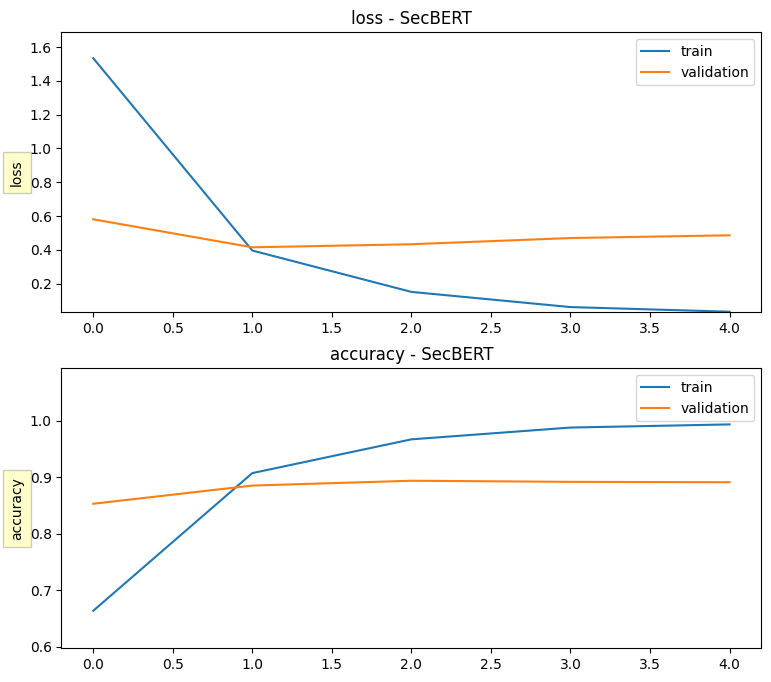

In [ ]:
def make_plot(axs, history, model_name='secBERT'):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    for i, metric in enumerate(['loss', 'accuracy']):
        train_metric = np.array(history[metric])
        val_metric = np.array(history[f'val_{metric}'])

        print(f'{metric} - Train metric type: {type(train_metric)}, Val metric type: {type(val_metric)}')

        y_lim_lower = min(train_metric) * 0.9
        y_lim_upper = max(train_metric) * 1.1

        ax1 = axs[i]
        ax1.plot(train_metric, label='train')
        ax1.plot(val_metric, label='validation')
        ax1.set_title(f'{metric} - {model_name}')
        ax1.set_ylabel(metric, bbox=box)
        ax1.set_ylim(y_lim_lower, y_lim_upper)
        ax1.legend()

fig, axs = plt.subplots(2, 1, figsize=(10, 8))
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs, history, model_name='SecBERT')
fig.align_ylabels(axs)
fig.set_size_inches(10, 8)
plt.show()

In [ ]:
test_loss, test_accuracy = eval_model(model, test_loader)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')

Evaluating:   0%|          | 0/153 [00:00<?, ?it/s]<ipython-input-6-1c0b2152c7ac>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Evaluating: 100%|██████████| 153/153 [00:20<00:00,  7.64it/s]

Test loss: 0.376021225066259, Test accuracy: 0.9001969796454365


In [ ]:
def get_predictions(model, data_loader):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)
            predictions.extend(preds)
            true_labels.extend(labels)

    return torch.stack(predictions).cpu().numpy(), torch.stack(true_labels).cpu().numpy()

In [ ]:
y_pred, y_true = get_predictions(model, test_loader)

<ipython-input-6-1c0b2152c7ac>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


In [ ]:
target_names = list(label_map.keys())

In [ ]:
report = classification_report(y_true, y_pred, target_names=target_names)
print(report)

              precision    recall  f1-score   support

       T1573       0.90      0.90      0.90        20
       T1505       1.00      0.93      0.96        42
       T1027       0.81      0.91      0.86        47
       T1564       0.82      0.70      0.76        20
       T1071       0.95      0.93      0.94        45
       T1059       0.88      0.92      0.90        53
       T1074       0.94      0.98      0.96        45
       T1132       0.98      1.00      0.99        40
       T1574       0.78      0.82      0.80        22
       T1560       0.95      0.95      0.95        40
       T1113       1.00      1.00      1.00        36
       T1102       0.80      0.95      0.87        43
       T1553       0.83      0.94      0.88        31
       T1140       0.87      0.69      0.77        29
       T1543       0.82      0.82      0.82        17
       T1562       0.86      0.82      0.84        22
       T1005       0.96      0.96      0.96        55
       T1106       0.96    

In [ ]:
confusion_mtx = confusion_matrix(y_true, y_pred)
print(confusion_mtx)

[[18  0  0 ...  0  0  0]
 [ 0 39  0 ...  1  0  0]
 [ 1  0 43 ...  0  0  0]
 ...
 [ 0  0  0 ... 15  0  3]
 [ 0  0  0 ...  0 21  0]
 [ 0  0  0 ...  1  0 20]]


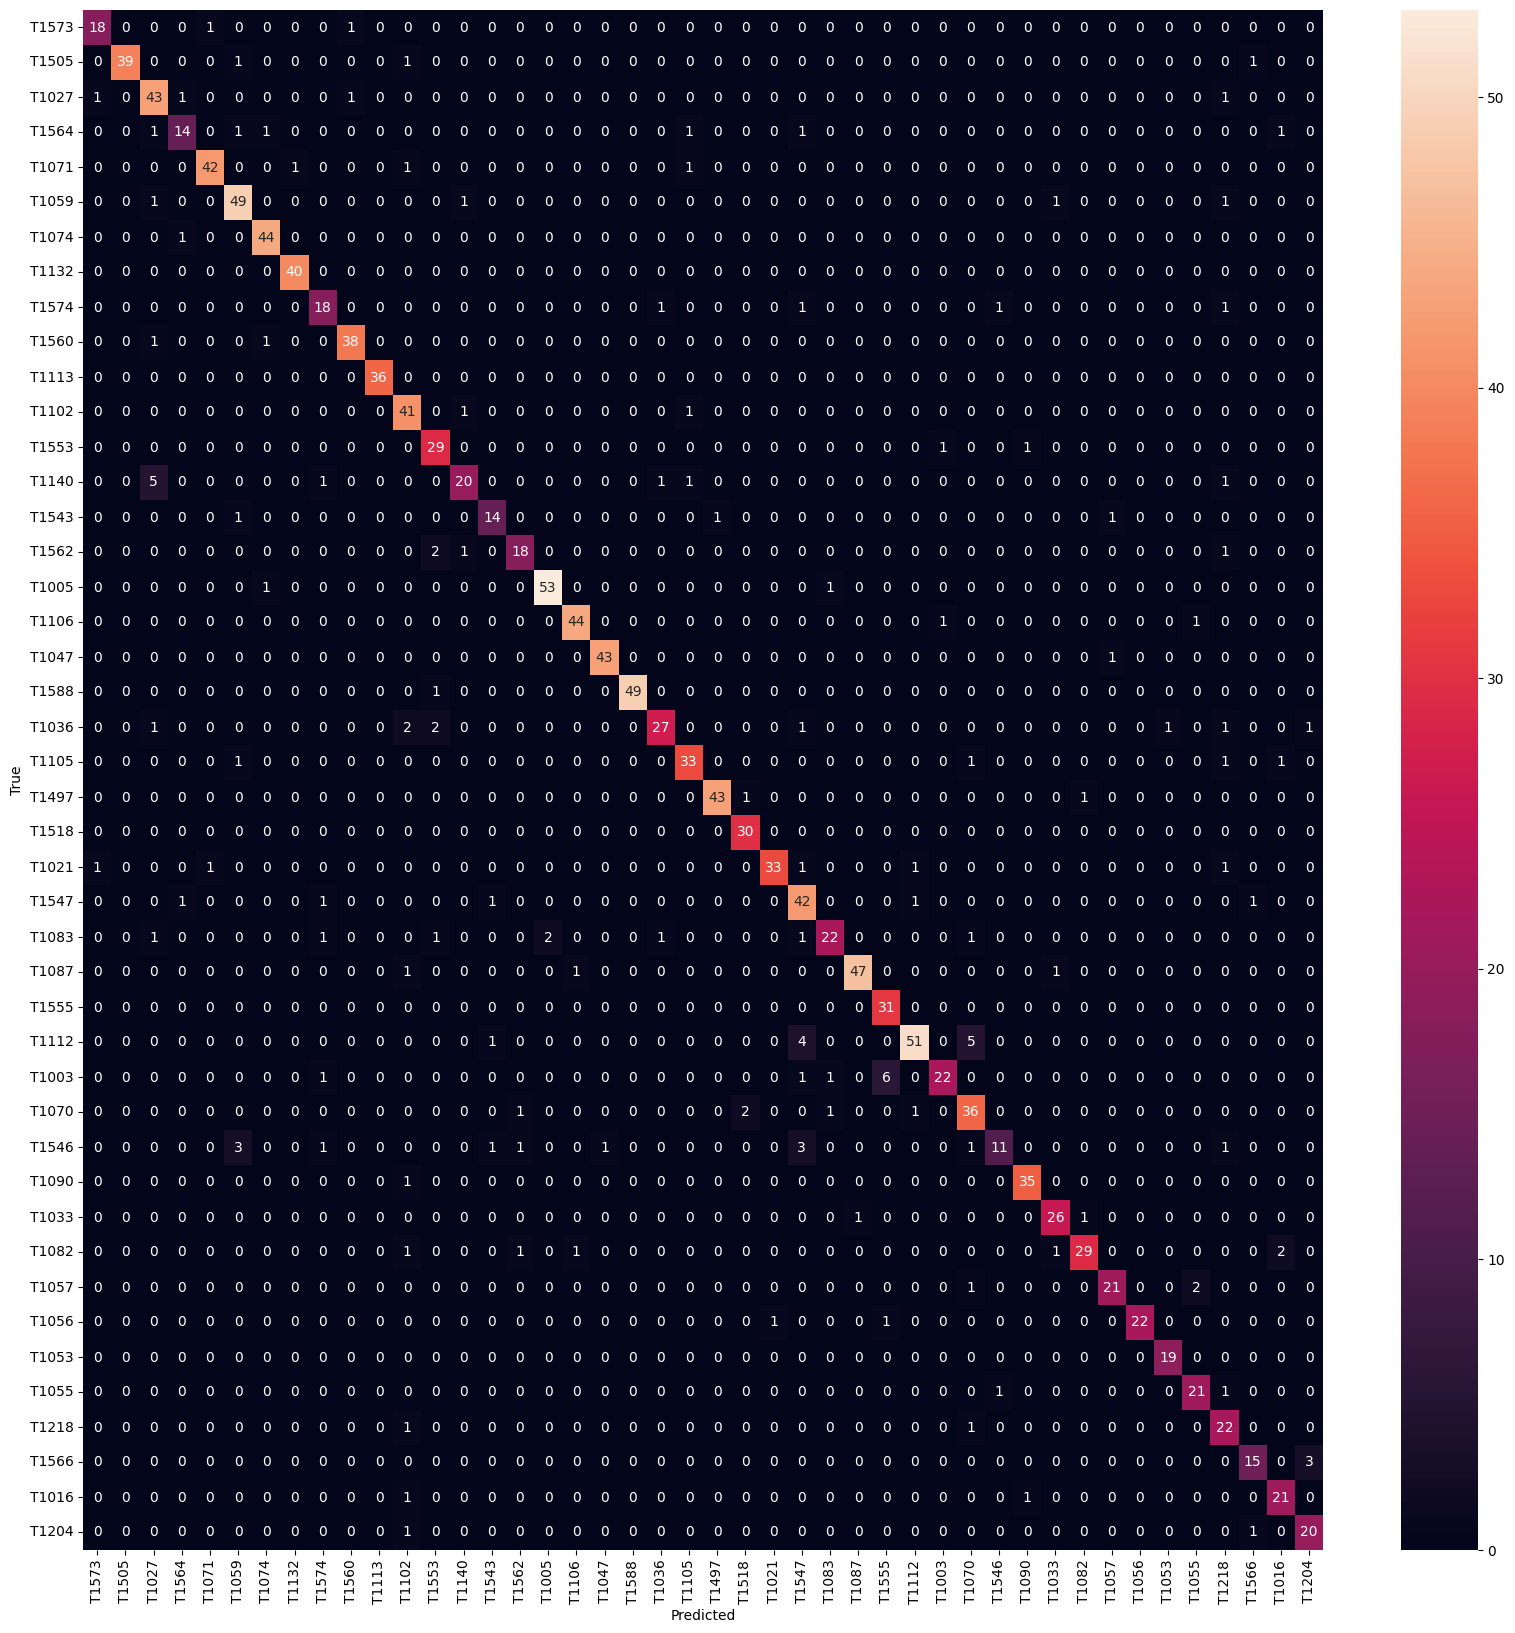

In [ ]:
plt.figure(figsize=(20, 20))
sns.heatmap(confusion_mtx, annot=True, fmt='d',
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()